In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
#import the raw data from the files
cl_kadij = np.genfromtxt("data/Cl_KadIJ_Merge_dt1h.tek", skip_header=29, skip_footer=1)
cl_lobith = np.genfromtxt("data/Cl_Lobith_Merge_dt1h.lss", skip_header=131, skip_footer=1)
afvoer_lobith = np.genfromtxt("data/Q_Lobith_Merge_dt1h.lss", skip_header=131, skip_footer=1)
stand_hvh = np.genfromtxt("data/h_HvH_Merge_dt1h.tek", skip_header=30, skip_footer=1)

In [3]:
#check if the different data files indeed had the same date and time on each row
if (np.sum(cl_kadij[:,:2] != cl_lobith[:,:2]) | np.sum(cl_lobith[:,:2] != afvoer_lobith[:,:2]) | np.sum(afvoer_lobith[:,:2] != stand_hvh[:,:2])):
    print("something is of")

print('shape of cl_kadij data:', np.shape(cl_kadij))
print('first five rows:')
print(cl_kadij[:5])

shape of cl_kadij data: (259633, 3)
first five rows:
[[  1.98201010e+07   0.00000000e+00   9.99999000e+02]
 [  1.98201010e+07   1.00000000e+04   9.99999000e+02]
 [  1.98201010e+07   2.00000000e+04   9.99999000e+02]
 [  1.98201010e+07   3.00000000e+04   9.99999000e+02]
 [  1.98201010e+07   4.00000000e+04   9.99999000e+02]]


In [4]:
# get rid of missing values (which are set to 999.999)
usable_indices = (cl_kadij[:,2] != 999.999) & (cl_lobith[:,3] != 999.999) & (afvoer_lobith[:,3] != 999.999) & (stand_hvh[:,2] != 999.999)
print("number of measurements present in all data:", np.sum(usable_indices))

time_data = ((np.genfromtxt("data/Cl_KadIJ_Merge_dt1h.tek", skip_header=29, skip_footer=1, dtype='str'))[:,:2])[usable_indices]
cl_kadij_data = (cl_kadij[:,2])[usable_indices]
cl_lobith_data = (cl_lobith[:,3])[usable_indices]
afvoer_lobith_data = (afvoer_lobith[:,3])[usable_indices]
stand_hvh_data = (stand_hvh[:,2])[usable_indices]
print("shapes:", np.shape(time_data), np.shape(cl_kadij_data), np.shape(cl_lobith_data), np.shape(afvoer_lobith_data), np.shape(stand_hvh_data))

number of measurements present in all data: 225964
shapes: (225964, 2) (225964,) (225964,) (225964,) (225964,)


In [5]:
# convert time_data into datetime format (this will take a while, several minutes!)
from datetime import datetime
datetime_data = np.array([]);
for row in range(len(time_data)):
    as_datetime = datetime.strptime(time_data[row,0] + " " + time_data[row,1], '%Y%m%d %H%M%S')
    datetime_data = np.append(datetime_data,as_datetime)

In [6]:
# put the data into a pandas data frame indexed by the datetimes
data = np.vstack((cl_kadij_data, cl_lobith_data, afvoer_lobith_data, stand_hvh_data))
data = np.transpose(data)
data = pd.DataFrame(data=data, index=datetime_data, columns=['cl_kadij', 'cl_lobith', 'afv_lobith', 'stand_hvh'])
data.head()

,cl_kadij,cl_lobith,afv_lobith,stand_hvh
1982-02-11 00:00:00,126.0,121.000,3679.88,-52.0
1982-02-11 01:00:00,116.0,112.223,3673.90,-55.0
1982-02-11 02:00:00,123.0,112.263,3668.01,-39.0
1982-02-11 03:00:00,126.0,112.359,3662.27,-8.0
1982-02-11 04:00:00,113.0,112.527,3656.70,86.0


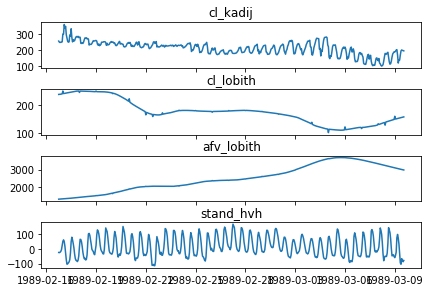

In [7]:
# some plots to make sure we have the right data:
f, ax_array = plt.subplots(4, sharex=True)
f.tight_layout()
plot_interval = slice(50000,50500)

ax_array[0].plot(data['cl_kadij'][plot_interval])
ax_array[0].set_title('cl_kadij')

ax_array[1].plot(data['cl_lobith'][plot_interval])
ax_array[1].set_title('cl_lobith')

ax_array[2].plot(data['afv_lobith'][plot_interval])
ax_array[2].set_title('afv_lobith')

ax_array[3].plot(data['stand_hvh'][plot_interval])
ax_array[3].set_title('stand_hvh');

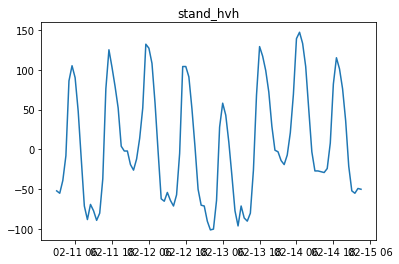

In [8]:
#stand_hvh fluctuates with tide, we need the "surge" part of it
plt.title('stand_hvh')
plt.plot(data['stand_hvh'][:100]);

In [9]:
# define some functions to quickly sum data over a number of timesteps:
def get_cumulative_data(data, num_steps):
    '''calculates the sum over the previous num_steps for the given data vector'''
    cum_data = [sum(data[i:i+num_steps]) for i in range(0, len(data) - num_steps + 1)]
    return cum_data

def get_cumulative_dataframe(data, var_name, num_steps, cum_name, timedelta):
    '''returns a pandas dataframe containing cumulative data, will detect gaps and fill the first num_steps-1 fields after each gap with NaN
       @param data: the dataframe containing the original data
       @param var_name: the name (string) of the variable of which the cumulative data is to be calculated
       @param num_steps: the number of steps over which to sum the data
       @param cum_name: the new column name (string) the cumulative variable will have in the returned dataframe
       @param timedelta: the timedelta to use when detecting gaps in the data'''
    cum_data = get_cumulative_data(data[var_name], num_steps)
    
    nan_array = np.empty(num_steps-1)
    nan_array[:] = np.NAN
    prepended_cum_data = np.insert(cum_data, 0, nan_array)
    
    gaps = (data.index.values[1:] - data.index.values[:-1]) != timedelta
    gap_indices = np.where(gaps == True)[0]
    for index in gap_indices:
        prepended_cum_data[index+1 : index+num_steps] = nan_array
    
    return pd.DataFrame(data=prepended_cum_data, index=data.index.values, columns=[cum_name])

def add_cumulative_data(data, var_name, num_steps, cum_name, timedelta):
    '''calculates the cumulative data using the get_cumulative_dataframe function then appends the given dataframe to the original dataframe'''
    df = get_cumulative_dataframe(data, var_name, num_steps, cum_name, timedelta)
    return pd.concat([data, df], axis=1)

In [10]:
# for now just sum the last 25 data points for stand_hvh, since tide cycle is approx 24 hours and 50 minutes
new_data = add_cumulative_data(data, 'stand_hvh', 25, 'cum_stand', np.timedelta64(1,'h'))
new_data_no_nan = new_data.dropna()
new_data_no_nan.head()

,cl_kadij,cl_lobith,afv_lobith,stand_hvh,cum_stand
1982-02-12 00:00:00,118.0,109.000,3564.12,-19.0,68.0
1982-02-12 01:00:00,113.0,118.004,3559.79,-26.0,94.0
1982-02-12 02:00:00,113.0,118.137,3555.49,-12.0,137.0
1982-02-12 03:00:00,117.0,118.192,3551.20,14.0,190.0
1982-02-12 04:00:00,103.0,118.151,3546.91,52.0,250.0


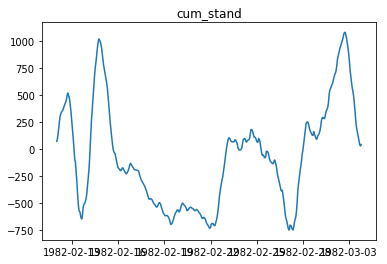

In [11]:
# plot the new cum_stand column to check results
plt.plot(new_data['cum_stand'][:500])
plt.title('cum_stand');

In [12]:
# now write the dataframe to a file:
new_data.to_csv('data/raw_data_unscaled.csv')
# note that we use the data that includes nan for cum_stand:
new_data.head()

,cl_kadij,cl_lobith,afv_lobith,stand_hvh,cum_stand
1982-02-11 00:00:00,126.0,121.000,3679.88,-52.0,NaN
1982-02-11 01:00:00,116.0,112.223,3673.90,-55.0,NaN
1982-02-11 02:00:00,123.0,112.263,3668.01,-39.0,NaN
1982-02-11 03:00:00,126.0,112.359,3662.27,-8.0,NaN
1982-02-11 04:00:00,113.0,112.527,3656.70,86.0,NaN
